In [100]:
import torch
import torch.nn
import torch.optim

import GraphX as gx
import ConnectionGraphX as cgx
import numpy as np
import networkx as nx
import scipy as sp

import ConnectionNetworkX as cnx

import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm


In [2]:
'''
phi,c: |V|d x 1
B: |E|d x |V|d      Connection incidence matrix
w: |E| x 1          Edge weights
c: |V|d x 1         c = alpha-beta; i.e. difference of densities
'''
def loss_fn(phi, B, w, c, alpha):
    loss0 = -torch.sum(phi*c)
    
    loss1 = torch.matmul(B, phi).reshape((w.shape[0],-1))
    loss1 = torch.linalg.norm(loss1, dim=1)
    loss1 = loss1 - w
    loss1 = torch.nn.ReLU()(loss1)
    loss1 = torch.sum(loss1**2)
    
    loss = loss0 + (0.5/alpha)*loss1
    return loss

In [3]:
def optimize(B, w, c, alpha, learning_rate, n_epochs, phi0 = None, print_freq=10):
    if phi0 is None:
        phi = torch.randn(B.shape[1], 1, requires_grad=True)
    else:
        phi = torch.tensor(phi0, requires_grad=True)
    optimizer = torch.optim.Adam([phi], lr=learning_rate)
    for epoch in range(n_epochs):
        # Compute loss
        loss = loss_fn(phi, B, w, c, alpha)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % print_freq == 0:
            print(f"epoch: {epoch}, loss: {loss:>7f}")
    return phi

# Define B, w and c

In [4]:
NODES = 2
EDGES = 1
seed = 42

a = nx.adjacency_matrix(nx.gnm_random_graph(NODES, EDGES, seed=seed))

# a = np.array([[0, 1, 1], [1, 0, 1], [1, 1, 0]])
g = gx.GraphX(sp.sparse.csr_matrix.toarray(a))

DIM_CONNECTION = 2
h = cgx.ConnectionGraphX(sp.sparse.csr_matrix.toarray(a), DIM_CONNECTION)

In [5]:
B = h.connectionIncidenceMatrix.T.astype('float32')
w = np.ones(B.shape[0]//DIM_CONNECTION).astype('float32')

np.random.seed(42)
def rand_prob_mass(n, d):
    mu = np.random.uniform(0, 1, (n, d)).astype('float32')
    mu = mu/(mu.sum(axis=0)[None,:])
    mu = mu.flatten()[:,None]
    return mu

mu = rand_prob_mass(h.nNodes, DIM_CONNECTION)
nu = rand_prob_mass(h.nNodes, DIM_CONNECTION)
c = (mu - nu)

In [6]:
c.reshape((h.nNodes, DIM_CONNECTION))

array([[-0.39023045,  0.46100134],
       [ 0.39023048, -0.46100134]], dtype=float32)

In [7]:
c.reshape((h.nNodes, DIM_CONNECTION)).sum(axis=0)

array([2.9802322e-08, 0.0000000e+00], dtype=float32)

# Check feasibility of B

In [36]:
c_sol, residuals, _, _ = np.linalg.lstsq(B.T, c.flatten())

/var/folders/0d/431gq5hn0_ngj8qfl5bt02680000gn/T/ipykernel_10316/186593914.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  c_sol, residuals, _, _ = np.linalg.lstsq(B.T, c.flatten())


In [37]:
residuals

array([0.], dtype=float32)

In [10]:
np.linalg.norm(c.flatten() - B.T.dot(c_sol).flatten())

2.9802322e-08

In [11]:
learning_rate = 0.01
alpha = 1e-5
n_epochs = 10000

B = torch.tensor(B)
w = torch.tensor(w)
c = torch.tensor(c)

optimize(B, w, c, alpha, learning_rate, n_epochs)

epoch: 0, loss: 228751.703125
epoch: 10, loss: 176010.703125
epoch: 20, loss: 131934.218750
epoch: 30, loss: 96605.726562
epoch: 40, loss: 69302.656250
epoch: 50, loss: 48812.609375
epoch: 60, loss: 33785.085938
epoch: 70, loss: 22969.662109
epoch: 80, loss: 15319.572266
epoch: 90, loss: 10004.984375
epoch: 100, loss: 6385.898438
epoch: 110, loss: 3976.064453
epoch: 120, loss: 2410.862793
epoch: 130, loss: 1421.367310
epoch: 140, loss: 813.651917
epoch: 150, loss: 451.629730
epoch: 160, loss: 242.761536
epoch: 170, loss: 126.217941
epoch: 180, loss: 63.423317
epoch: 190, loss: 30.806818
epoch: 200, loss: 14.506646
epoch: 210, loss: 6.687932
epoch: 220, loss: 3.098703
epoch: 230, loss: 1.527803
epoch: 240, loss: 0.875366
epoch: 250, loss: 0.619904
epoch: 260, loss: 0.526463
epoch: 270, loss: 0.494959
epoch: 280, loss: 0.485364
epoch: 290, loss: 0.482825
epoch: 300, loss: 0.482283
epoch: 310, loss: 0.482209
epoch: 320, loss: 0.482201
epoch: 330, loss: 0.482196
epoch: 340, loss: 0.482193


tensor([[ 0.3795],
        [-0.0335],
        [ 0.4977],
        [ 0.8912]], requires_grad=True)

# Working example

In [12]:
w = np.ones(1)
d = 2
sigma = np.eye(d)
B = np.block([np.sqrt(w)*np.eye(d), -np.sqrt(w)*sigma])

np.random.seed(42)
mu = np.random.uniform(0, 1, d)
mu = mu/mu.sum()
nu = np.random.uniform(0, 1, d)
nu = nu/nu.sum()
c = mu-nu
optim_val = np.linalg.norm(c)
optim_phi = c/np.linalg.norm(c)
c = np.block([c,-c])
c = c.reshape((2*d,1))

phi0 = np.block([optim_phi,optim_phi*0]).reshape(2*d,1)

print(B)
print(w)
print(c)
print(phi0)
print(optim_val)

B = torch.tensor(B.astype('float32'))
w = torch.tensor(w.astype('float32'))
c = torch.tensor(c.astype('float32'))
phi0 = phi0.astype('float32')

[[ 1.  0. -1. -0.]
 [ 0.  1. -0. -1.]]
[1.]
[[-0.26748401]
 [ 0.26748401]
 [ 0.26748401]
 [-0.26748401]]
[[-0.70710678]
 [ 0.70710678]
 [-0.        ]
 [ 0.        ]]
0.37827952162613965


# Solve Beckmann - connection problem

In [13]:
learning_rate = 0.001
alpha = 1e-1
n_epochs = 10000

In [14]:
optimize(B, w, c, alpha, learning_rate, n_epochs, phi0=phi0)

epoch: 0, loss: -0.378280
epoch: 10, loss: -0.384847
epoch: 20, loss: -0.385245
epoch: 30, loss: -0.385234
epoch: 40, loss: -0.385434
epoch: 50, loss: -0.385405
epoch: 60, loss: -0.385434
epoch: 70, loss: -0.385430
epoch: 80, loss: -0.385434
epoch: 90, loss: -0.385434
epoch: 100, loss: -0.385434
epoch: 110, loss: -0.385434
epoch: 120, loss: -0.385434
epoch: 130, loss: -0.385434
epoch: 140, loss: -0.385434
epoch: 150, loss: -0.385434
epoch: 160, loss: -0.385434
epoch: 170, loss: -0.385434
epoch: 180, loss: -0.385434
epoch: 190, loss: -0.385434
epoch: 200, loss: -0.385434
epoch: 210, loss: -0.385434
epoch: 220, loss: -0.385434
epoch: 230, loss: -0.385434
epoch: 240, loss: -0.385434
epoch: 250, loss: -0.385434
epoch: 260, loss: -0.385434
epoch: 270, loss: -0.385434
epoch: 280, loss: -0.385434
epoch: 290, loss: -0.385434
epoch: 300, loss: -0.385434
epoch: 310, loss: -0.385434
epoch: 320, loss: -0.385434
epoch: 330, loss: -0.385434
epoch: 340, loss: -0.385434
epoch: 350, loss: -0.385434
epo

tensor([[-0.7205],
        [ 0.7205],
        [ 0.0134],
        [-0.0134]], requires_grad=True)

# Attempt Beckmann on Puppet Connection Graph

Initialize the puppet connection graph

In [16]:
p = "/Users/sawyerjack/IdeaProjects/project_data/PuppetsData"

N_PUPPET_IMAGES = 250
NEAREST_NEIGHBORS = 7
INTRINSIC_DIMENSION = 2

puppetGraph = cnx.cnxFromImageDirectory(p, INTRINSIC_DIMENSION, k=NEAREST_NEIGHBORS, nImages=N_PUPPET_IMAGES)


X.shape =  (8100, 100)
local_opts['k_nn0'] = 175 is created.
Options provided:
local_opts:
{
    "Atilde_method": "LDLE_1",
    "N": 100,
    "U_method": "k_nn",
    "algo": "LPCA",
    "alpha": 1,
    "debug": true,
    "delta": 0.9,
    "gl_type": "unnorm",
    "k": 7,
    "k_nn": 49,
    "k_nn0": 175,
    "k_tune": 7,
    "lambda1_decay": 0.75,
    "lambda1_init": 8,
    "lambda1_min": 0.001,
    "max_iter": 300,
    "max_sparsity": 0.9,
    "metric": "euclidean",
    "n_proc": 6,
    "p": 0.99,
    "power": 5,
    "pp_n_thresh": 32,
    "radius": 0.5,
    "reg": 0.0,
    "scale_by": "gamma",
    "tau": 50,
    "to_postprocess": true,
    "verbose": true
}
intermed_opts:
{
    "algo": "best",
    "debug": true,
    "eta_max": 25,
    "eta_min": 5,
    "len_S_thresh": 256,
    "local_algo": "LPCA",
    "metric": "euclidean",
    "n_proc": 6,
    "n_times": 4,
    "verbose": true
}
global_opts:
{
    "add_dim": false,
    "align_transform": "rigid",
    "align_w_parent_only": true,
  

100%|██████████| 250/250 [00:03<00:00, 64.68it/s] 


Proportion of edges which were removed due to remoteness:  0.05200433369447454
[0.78646447 0.72583211 0.66752523 0.5541984  0.53426464 0.52931517
 0.52077728 0.48831005 0.44075418 0.31245065]
MOST LIKELY INCONSISTENT: |lambda_min| >= 1e-8. 


Setting up B, c, w for the puppet graph

In [65]:
puppetB = puppetGraph.connectionIncidenceMatrix.T.astype('float32')
puppetW = np.ones(puppetB.shape[0]//INTRINSIC_DIMENSION).astype('float32')

np.random.seed(42)

#puppetMu = rand_prob_mass(puppetGraph.nNodes, INTRINSIC_DIMENSION)
#puppetNu = rand_prob_mass(puppetGraph.nNodes, INTRINSIC_DIMENSION)

puppetMu = np.zeros((puppetGraph.nNodes * INTRINSIC_DIMENSION,1))
puppetMu[0:2, :] = [[1],[1]]
puppetNu = np.zeros((puppetGraph.nNodes * INTRINSIC_DIMENSION,1))
puppetNu[2:4, :] = [[1],[1]]

puppetC = (puppetMu - puppetNu)

puppetC.reshape((puppetGraph.nNodes, INTRINSIC_DIMENSION))
puppetC.reshape((puppetGraph.nNodes, INTRINSIC_DIMENSION)).sum(axis=0)


array([0., 0.])

Checking Feasibility - looks good

In [82]:
print(type(puppetC))
print(type(puppetB))
c_sol, residuals, _, _ = np.linalg.lstsq(sp.sparse.lil_matrix.toarray(puppetB.T), puppetC)

# I didn't rename the dummy variables here- caution.

np.linalg.norm(puppetC.flatten() - puppetB.T.dot(c_sol).flatten())
#np.linalg.norm(c_sol)


<class 'numpy.ndarray'>
<class 'scipy.sparse._lil.lil_matrix'>


/var/folders/0d/431gq5hn0_ngj8qfl5bt02680000gn/T/ipykernel_10316/1989130843.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  c_sol, residuals, _, _ = np.linalg.lstsq(sp.sparse.lil_matrix.toarray(puppetB.T), puppetC)


7.038512238125024e-15

Attempt to plug into the optimization methods

In [76]:
learning_rate = 0.01
alpha = 1e-5
n_epochs = 10000

B = torch.tensor(sp.sparse.lil_matrix.toarray(puppetB))
w = torch.tensor(puppetW)
c = torch.tensor(puppetC)

puppetPhi = optimize(B, w, c, alpha, learning_rate, n_epochs)

epoch: 0, loss: 97277414.162667
epoch: 10, loss: 74001910.118422
epoch: 20, loss: 55853761.993668
epoch: 30, loss: 42072997.916103
epoch: 40, loss: 31770933.881175
epoch: 50, loss: 24116785.847468
epoch: 60, loss: 18424757.817725
epoch: 70, loss: 14174287.791643
epoch: 80, loss: 10987233.767936
epoch: 90, loss: 8580307.747824
epoch: 100, loss: 6747789.724566
epoch: 110, loss: 5342511.217097
epoch: 120, loss: 4256491.729617
epoch: 130, loss: 3410410.245002
epoch: 140, loss: 2746469.509840
epoch: 150, loss: 2222029.277367
epoch: 160, loss: 1805440.545411
epoch: 170, loss: 1473193.561395
epoch: 180, loss: 1207358.826901
epoch: 190, loss: 993824.963552
epoch: 200, loss: 821577.972468
epoch: 210, loss: 682056.418177
epoch: 220, loss: 568859.551267
epoch: 230, loss: 476648.871913
epoch: 240, loss: 401189.005189
epoch: 250, loss: 339147.044794
epoch: 260, loss: 287865.146903
epoch: 270, loss: 245237.186507
epoch: 280, loss: 209566.835670
epoch: 290, loss: 179524.047661
epoch: 300, loss: 15409

In [77]:
np.linalg.norm(puppetPhi.detach().numpy())

8.93179

Doing some post-hoc illustration- want to see "active edges"

In [120]:
print(c_sol.shape)

TOLERANCE = 5e-2
for edge in range(1846):
    if abs(c_sol[edge]) < TOLERANCE:
        c_sol[edge] = 0

# with np.printoptions(threshold=np.inf):
    # print(c_sol)


(1846, 1)


100%|██████████| 250/250 [00:01<00:00, 203.66it/s]


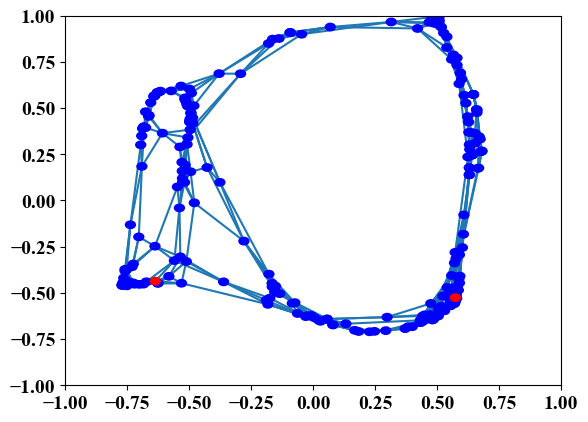

In [119]:
fig, ax = plt.subplots()
plt.xlim((-1, 1))
plt.ylim((-1, 1))
nodeData = nx.spectral_layout(puppetGraph, dim=2)

for edge in tqdm(list(puppetGraph.edges)):

    fromNode = edge[0]
    toNode = edge[1]
    centerFromNode = nodeData[fromNode][0], nodeData[fromNode][1]
    centerToNode = nodeData[toNode][0], nodeData[toNode][1]

    edgeLabel = matplotlib.lines.Line2D((centerFromNode[0], centerToNode[0]), (centerFromNode[1], centerToNode[1]))
    edgeLabel.zorder = -100
    ax.add_line(edgeLabel)

for node in tqdm(list(range(2, N_PUPPET_IMAGES)) + [0, 1]):
    center = nodeData[node][0], nodeData[node][1]
    if node in [0,1]:
        col="r"
        #ax.text(center[0], center[1], str(node+1))
    else:
        col="b"
    nodeLabel = matplotlib.patches.Circle(center, radius=2e-2, color=col)
    ax.add_patch(nodeLabel)

# Want to color "active" edges red. WIP.
# Noticed that CNX has an issue- not properly removing the remote edges. Zeroing the Connection incidence is not enough.
